In [1]:
from qa_qc_lib.qa_qc_gis import QA_QC_GIS_second, QA_QC_GIS_first
import pandas as pd

In [2]:
kern = pd.read_excel('qa_qc_lib/data/Керн1.xlsx')
depth = kern['Глубина отбора образца после привязки к ГИС, м'].to_numpy()
poro = kern['Открытая пористость по воде, Кп, %'].to_numpy()
lithology = kern['Литологическое описание'].to_numpy()
poroeff = kern['Эффективная пористость, Кп эф, %'].to_numpy()
perm = kern['Газопроницаемость параллельно напластованию, Кпр, мД'].to_numpy()

Тестирование качества увязки литологии по ГИС и литологии по керну

Процент совпавших литотипов по ГИС и по керну равен  90.14084507042254 %
Оранжевыми точками отмечены глубины, в которых литология не увязана. В литологии по керну 1 - песчаник, 2 - алевролит, 3 - аргиллит


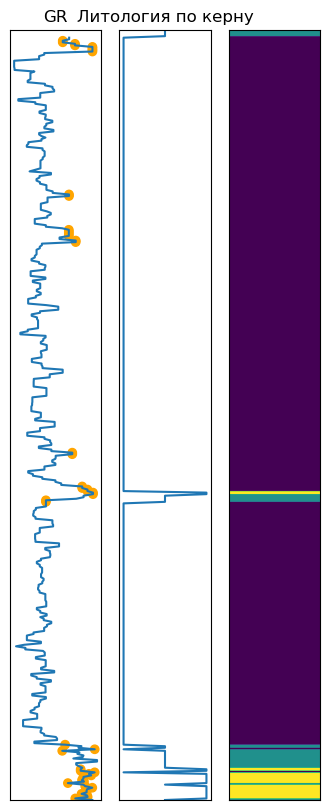


Тестирование на сходство максимальных отметок глубин по отбивкам и по ГИС

Максимальная глубина по отбивке 2142, максимальная глубина по ГИС 2468.1. Тест пройден

Тестирование качества увязки открытой пористости, эффективной пористости и проницаемости по керну с этими же свойствами по РИГИС



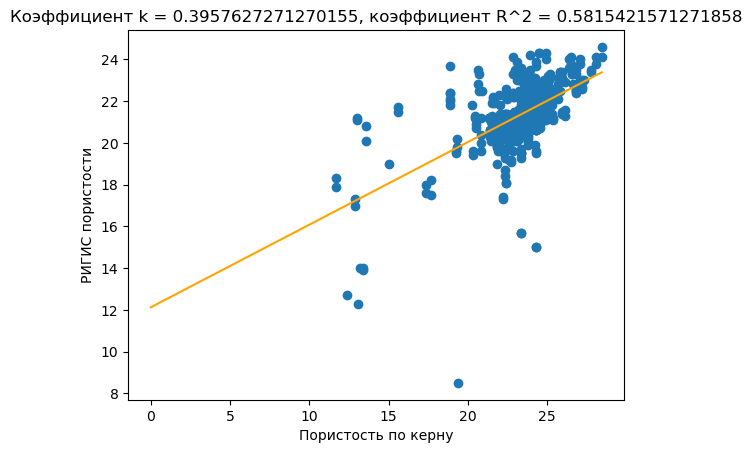


В файле с керном нет таких глубин, на которых были бы данные по эффективной пористости и по открытой пористости



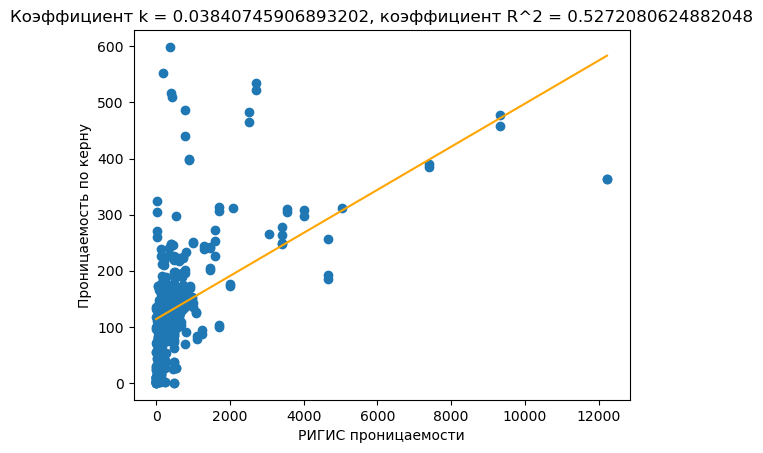

Перекрытия интервалов в данных нет
В каротаже gr пропуски на следующих глубинах:
2090.41 - 2090.7
В каротаже rhob пропуски больше 0.5м. 



In [3]:
las_path = 'qa_qc_lib/data/9281PL.las'
qaqcc = QA_QC_GIS_second(las_path, (2083, 2142), poro, perm, poroeff, lithology, depth)
qaqcc.start_tests()

In [4]:
las_path = 'qa_qc_lib/data/9281PL.las'
qaqc = QA_QC_GIS_first(las_path = las_path)

In [5]:
list_of_tests = qaqc.get_list_of_tests()
qaqc.start_tests(list_of_tests)

True
True
